In [2]:
import random

from magesim import env
import gym

import numpy as np
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
env = gym.make('magesim-v0')

In [5]:
print(env.__doc__)
del env

TBC MageSim Wrapper Env

    Currently only supports offensive spell actions; supported spells below:
        ARCANE_BLAST = 30451
        ARCANE_MISSILES = 38699
        FROSTBOLT = 27072
        FIREBALL = 27070
        SCORCH = 27074
        PYROBLAST = 33938

    Current observation space struct has follow fields, more details see env.h:
        double t;
        double gcd;
        double mana;
        double duration;
        Spec spec;
        int dmg;
        int mana_emerald;
        int mana_ruby
    


Among these features are 4 relatively informative ones and they relate to three latent factors:

1. Mana availibility
2. Spec
3. Time until environment termination

Some prelim `spinup` runs have been unfruitful so I'm going to start super simple with MAB trained via Exp3. We should learn what spells to **not** cast.

In [6]:
def p(i):
    return (1 - gamma) * w[i] / w.sum() + gamma / K

def sample():
    return random.choices(population=actions, weights=w)[0]

In [12]:
gamma = 0.2
K = 6
# Empirically safe bound.
# Exp3 requires that reward is in [0,1].
damage_bound = 10000
w = np.ones(K)
actions = np.arange(K)

epochs = 100
average_reward = []
log_buffer = []

env = gym.make('magesim-v0')

for _ in range(epochs):
    log_buffer.append("-- New Epoch")
    done = False
    episode_rewards = []
    while not done:
        action = sample()
        _, r, done, _ = env.step(action)
        x = np.zeros(K)
        x[action] = r / (p(action) * damage_bound)
        w *= np.exp(gamma * x / K)

        # Bookkeeping
        episode_rewards.append(r)
        log_buffer.append((x, r, action))
        
    env.render()
    average_reward.append(np.mean(episode_rewards))
    
    env.reset()

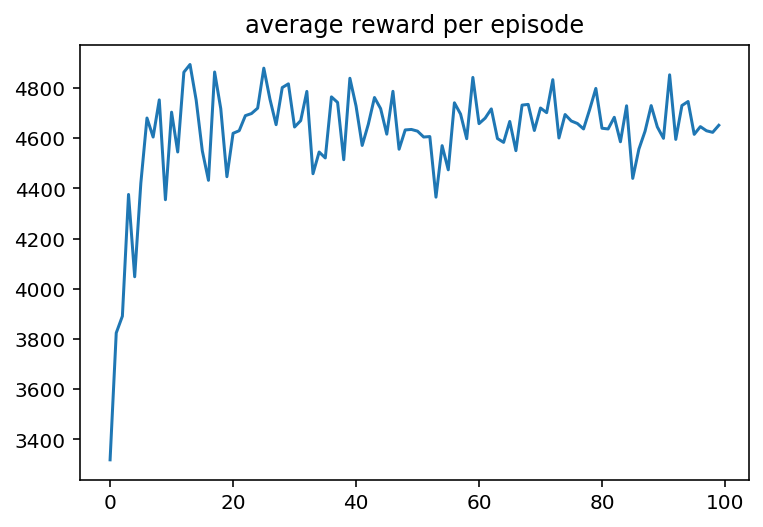

In [13]:
plt.plot(average_reward);
plt.title("average reward per episode");

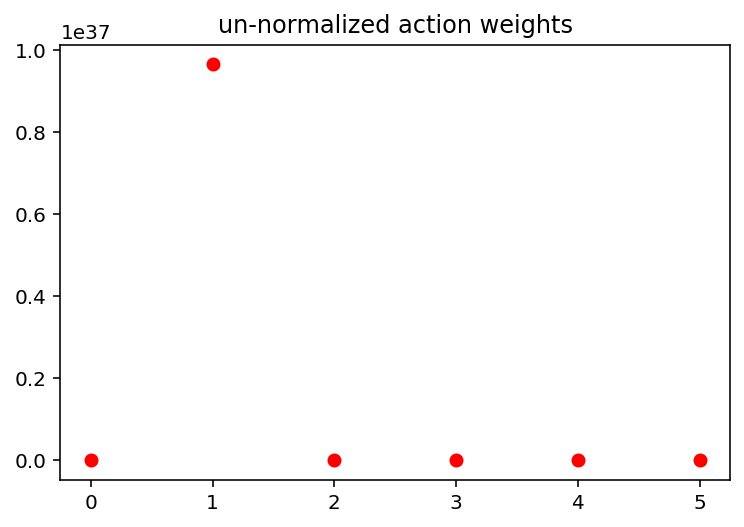

In [14]:
plt.title("un-normalized action weights")
plt.plot(w, 'ro');

After multiple iterations it's clear the algorithm picks [1] which is 'Arcane Missiles'.
Initially this surprised me but after some thought it actually made alot of sense, heres some observations and why:

- Running AM over a 200 second episode doesn't lead to OOM, which means we won't have an "empty" (0 damage) cast.
- Non-contextual bandit policy can't anticipate OOM or select actions in time / state dependent matter; so best to avoid it.
- AM has the highest overall damage, but worse DPS than AB.
- Exp3 treats all steps as drawn from the same "episode", i.e: the regret is defined w.r.t to all steps across episodes not across steps within episodes, therefore all steps are treated as equivalent; AM does more damage than AB and is thus selected.

In [69]:
from pprint import pprint
np.set_printoptions(precision=3)
# for r in log_buffer: pprint(r)

In [ ]:
np.sum